## Housing Prices

### 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from scipy import stats
from scipy.stats import norm
from scipy.stats import pointbiserialr
from scipy.stats import f_oneway

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor

### 2. Import Data

In [2]:
dir = os.getcwd()
train_data = pd.read_csv(os.path.join(dir,'input', 'train.csv'))
test_data = pd.read_csv(os.path.join(dir,'input', 'test.csv'))

### 3. Exploratory Data Analysis (EDA)

In [6]:
def basic_eda_info (df, name='DataFrame'):

    print(f'=== {name}: Basic Information ===')
    print(f'Shape: {df.shape}')

    print('='*60)
    print('=== Head of DataFrame ===')
    display(df.head())

    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print('=== Numeric Describe ===')
        display(df.describe())
    
    print('='*60)
    print('=== Missing Values ===')
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values != 0]
    missing_values = missing_values.sort_values(ascending=False)
    print(missing_values)
    print('=' * 60)

In [66]:
def categorical_continuous_analysis(df, target, p_threshold=0.05, std_multiplier=0.15):
    results = {}
    cat_cols = df.select_dtypes(include='object').columns
    target_std = df[target].std()
    std_threshold = target_std * std_multiplier
    
    for col in cat_cols:
        groups = [df[df[col] == val][target].dropna() for val in df[col].dropna().unique()]
        
        if len(groups) <= 1:
            continue
        
        try:
            # ANOVA F-test
            f_val, p_val = f_oneway(*groups)
        except:
            f_val, p_val = float('nan'), float('nan')
        
        mean_per_cat = df.groupby(col)[target].mean()
        std_dev = mean_per_cat.std()
        mean_range = mean_per_cat.max() - mean_per_cat.min()
        
        keep = "Yes" if (p_val < p_threshold and std_dev > std_threshold) else "No"

        results[col] = {
            # 'F-statistic': f_val,
            'P-Value': p_val,
            'Mean STD': std_dev,
            # 'Mean Range': mean_range,
            'Keep': keep
        }

    return pd.DataFrame(results).T.sort_values(by='Keep', ascending=False)

In [4]:
def y_distribution(y):
    sns.histplot(y, kde=True, stat='density', label="Data")
    sns.kdeplot(y, label="Normal Fit", color='red', linestyle="--")
    
    plt.title("Distribution of y with Normal Fit")
    plt.legend()
    plt.show()

    stats.probplot(y, plot=plt)
    plt.title("Q-Q Plot of y")
    plt.show()

In [37]:
def compare_bivariate (variable_x, y):
    fig, ax = plt.subplots()
    ax.scatter(variable_x, y)
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel('GrLivArea', fontsize=13)
    plt.show()

In [ ]:
def correlation_analysis(X, y, numeric_cols=None, threshold=0.5, graphic='yes'):

    combined_df = X[numeric_cols].copy()
    combined_df["Target"] = y

    corr_df = combined_df.corr()
    filtered_corr = corr_df[((corr_df > threshold) | (corr_df < -threshold)) & (corr_df != 1) & (corr_df != -1)]
    filtered_corr = filtered_corr.dropna(axis=0, how='all') #drop NaN rows
    filtered_corr = filtered_corr.dropna(axis=1, how='all') #drop NaN columns
        
    if graphic == 'yes': 
        # Plot heatmap
        plt.figure(figsize=(12, 5))
        sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Heatmap (Regression)')
        plt.show()

    return filtered_corr

### 4. Practice Dataset - EDA

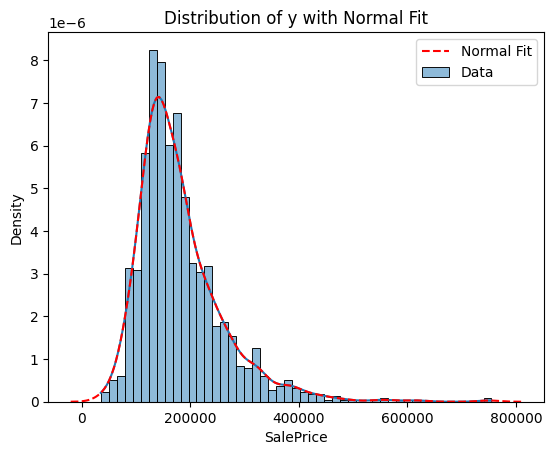

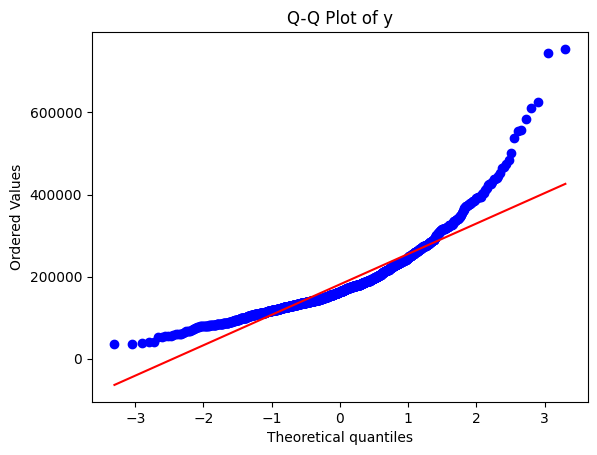

In [ ]:
y_distribution(train_data['SalePrice'])
# In this case: Right Skewed
# In case of positive skewness, log transformations usually works well.

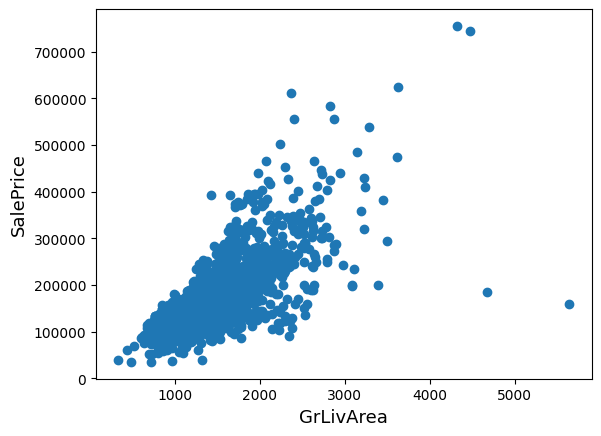

In [ ]:
compare_bivariate(train_data['GrLivArea'],train_data['SalePrice'])
# Have to delete the 2 outliers (4500, 5500) because they don't follow the trend

In [42]:
# basic_eda_info(train_data)

In [69]:
categorical_results = categorical_continuous_analysis(train_data, 'SalePrice')
categorical_results.loc[categorical_results.Keep == "No"]

,P-Value,Mean STD,Keep
LandSlope,0.141396,12492.542327,No
Utilities,0.584717,30724.466216,No
PoolQC,0.303985,162523.09077,No
MiscFeature,0.104728,64500.725437,No
Street,0.117049,36020.046667,No


In [ ]:
categorical_to_select = list(categorical_results.loc[categorical_results.Keep == "Yes"].index)
missing_data(train_data[categorical_to_select])

                                                  
Missing in df:
..................................................


,Missing Values,Percent,Analysis
Alley,1369,93.77,Delete
Fence,1179,80.75,Delete
MasVnrType,872,59.73,Delete
FireplaceQu,690,47.26,Keep
GarageFinish,81,5.55,Keep
GarageType,81,5.55,Keep
GarageCond,81,5.55,Keep
GarageQual,81,5.55,Keep
BsmtExposure,38,2.60,Keep
BsmtFinType2,38,2.60,Keep


### 5. Data Cleaning

#### 5.1 Missing data

In [14]:
def missing_data(df, threshold = 0.5):
    print(" " * 50)
    print(f"Missing in df:")
    print("." * 50)
    
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values != 0]
    
    total_rows = len(df)
    missing_percent = ((missing_values / total_rows) * 100).round(2)
    analysis = ["Delete" if percent > threshold*100 else "Keep" for percent in missing_percent]

    missing_summary = pd.DataFrame({
        'Missing Values': missing_values,
        'Percent': missing_percent,
        'Analysis' : analysis
    })

    missing_summary = missing_summary.sort_values(by='Missing Values', ascending=False)
    
    return missing_summary

#### 5.2 Missing data on BsmtQual

In [15]:
def replace_BsmtQual (df):
    df['BsmtQual'] = df['BsmtQual'].fillna('TA')

    return df

#### 5.3 Missing data on MasVnrArea

In [16]:
def replace_MasVnrArea (df):
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

    return df

#### 5.4 Missing data on Test_DF

In [17]:
def replace_on_test (df):

    # Replace categorical missing values with the mode for each column only when is really big the missing
    
    # Replace numerical missing values
    df['GarageCars'] = df['GarageCars'].fillna(0)
    df['GarageArea'] = df['GarageArea'].fillna(0)
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].mean())
    
    return df

### 6. Featuring Engineering

#### 6.1 Merging supplementary data

In [26]:
def add_features_columns (df):
    # Add ratios or flags, not arithmethics values

    df['Property_Age'] = df['YrSold'] - df['YearBuilt']
    df['Years_Remodel'] = df['YrSold'] - df['YearRemodAdd']
    df['Has_2nd_Floor'] = (df['2ndFlrSF'] > 0).astype(int)
    df['Bedroom_Ratio'] = df['BedroomAbvGr'] / df['TotRmsAbvGrd']
    df['Has_Garage'] = df['GarageCars'].apply(lambda x: 1 if x>0 else 0)
    df['Large_Garage'] = (df['GarageCars'] >=3).astype(int)

    return df

In [27]:
def add_factorize_or_encode(X_train, X_valid, X_test, task="classification"):

    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

    if task == "classification":
        if len(categorical_cols) > 0:
            print(f"Encoding categorical columns: {list(categorical_cols)}")
            for col in categorical_cols:
                encoder = LabelEncoder()
                X_train[col] = encoder.fit_transform(X_train[col].astype(str))
                X_valid[col] = encoder.transform(X_valid[col].astype(str))
                X_test[col] = encoder.transform(X_test[col].astype(str))

    elif task == "regression":
        if len(categorical_cols) > 0:
            print(f"One-hot encoding categorical columns: {list(categorical_cols)}")

            encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")

            X_train_encoded = pd.DataFrame(
                encoder.fit_transform(X_train[categorical_cols]),
                columns=encoder.get_feature_names_out(categorical_cols),
                index=X_train.index
            )
            X_valid_encoded = pd.DataFrame(
                encoder.transform(X_valid[categorical_cols]),
                columns=encoder.get_feature_names_out(categorical_cols),
                index=X_valid.index
            )
            X_test_encoded = pd.DataFrame(
                encoder.transform(X_test[categorical_cols]),
                columns=encoder.get_feature_names_out(categorical_cols),
                index=X_test.index
            )

            # Reindex validation and test sets to match training columns
            X_valid_encoded = X_valid_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
            X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

            # Drop original categorical columns and concatenate encoded ones
            X_train = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded], axis=1)
            X_valid = pd.concat([X_valid.drop(columns=categorical_cols), X_valid_encoded], axis=1)
            X_test = pd.concat([X_test.drop(columns=categorical_cols), X_test_encoded], axis=1)

            # Ensure no NaN values after encoding
            X_train.fillna(0, inplace=True)
            X_valid.fillna(0, inplace=True)
            X_test.fillna(0, inplace=True)

    else:
        raise ValueError("Invalid task. Please choose 'classification' or 'regression'.")

    return X_train, X_valid, X_test


#### 6.2 Standarizing the data

In [22]:
def discretise_numeric(X_train, X_val, X_test, numeric_cols, no_bins=10, strategy='uniform'):
    """
    Discretizes the specified numeric columns into bins for X_train, X_val, and X_test using KBinsDiscretizer.
    The binning is fitted on X_train and then applied to X_val and X_test to avoid data leakage.
    Ensures no NaN values by using ordinal encoding.
    
    Parameters:
    - strategy: Binning strategy ('uniform', 'quantile', 'kmeans')
    """
    # Copy inputs to avoid modifying the original datasets
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()
    
    # Apply KBinsDiscretizer
    discretizer = KBinsDiscretizer(n_bins=no_bins, encode='ordinal', strategy=strategy)
    
    # Fit on X_train
    X_train[numeric_cols] = discretizer.fit_transform(X_train[numeric_cols])
    
    # Transform X_val and X_test using the same discretizer
    X_val[numeric_cols] = discretizer.transform(X_val[numeric_cols])
    X_test[numeric_cols] = discretizer.transform(X_test[numeric_cols])
    
    return X_train, X_val, X_test

In [23]:
def standardize_values(X_train, X_val, X_test, numeric_cols):
    """
    Standardizes specified numeric columns in X_train, X_val, and X_test.
    The scaler is fitted on X_train and applied to X_val and X_test.
    """
    # Ensure inputs are copies to avoid modifying the original datasets
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()

    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler on X_train
    scaler.fit(X_train[numeric_cols])

    # Transform X_train, X_val and X_test
    X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
    X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train, X_val, X_test

In [24]:
def equal_dataframes(X_train, X_val, X_test):
    """
    Aligns X_train, X_val, and X_test to have the same columns by adding missing columns
    or removing extra columns.
    """
    # Ensure inputs are copies to avoid modifying original data
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()

    # Reference columns from X_train
    common_columns = X_train.columns

    # Add missing columns to X_val and X_test (with default values as 0)
    for col in common_columns:
        if col not in X_val.columns:
            X_val[col] = 0
        if col not in X_test.columns:
            X_test[col] = 0

    # Remove extra columns in X_val and X_test that are not in X_train
    X_val = X_val[common_columns]
    X_test = X_test[common_columns]

    return X_train, X_val, X_test

#### 6.3 Final features & cleaning selection

In [28]:
def pre_clean_df (df, selected_columns):
    
    #Only to show missing data from selected columns
    df = add_features_columns(df)
    df = df[selected_columns]
    missing_data (df)


In [29]:
def clean_df (df, selected_columns, drop_columns):
    
    # Do all the steps together
    df = replace_BsmtQual(df)
    df = replace_MasVnrArea(df)
    df = replace_on_test(df)
    df = add_features_columns(df)
    df = df[selected_columns]
    missing_data (df)
    df = df.drop(drop_columns, axis=1)
    
    return df

In [30]:
def binary_columns (df):
    binary_cols = df.select_dtypes(include=['number']).columns[
        (df.min() == 0) & (df.max() == 1)
    ]
    return list(binary_cols)

In [31]:
def numerical_non_binary_columns (df):
    numeric_cols = df.select_dtypes(include=['number'])

    non_binary_numeric_cols = numeric_cols.loc[:, ~((numeric_cols.min() == 0) & (numeric_cols.max() == 1))]

    return list(non_binary_numeric_cols.columns)

### 7. Practice Dataset - Analysis & premodeling work

In [63]:
selected_columns = ["Id", "MSZoning", "LotArea", "LotShape", "LotConfig", "Neighborhood", "OverallQual", "Property_Age", "Years_Remodel", "MasVnrArea", "ExterCond", "Foundation",
                     "BsmtQual", "Heating", "Has_2nd_Floor", "GrLivArea", "FullBath", "KitchenQual", "Bedroom_Ratio", "Fireplaces", "Has_Garage", "Large_Garage", "SaleType",
                     "SaleCondition"]
to_delete_columns = ["YearBuilt", "YearRemodAdd", "GarageCars", 'YrSold']
dependent = ["SalePrice"]
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64'] and cname not in ['SalePrice', 'GarageYrBlt', 'LotFrontage']]

selected_columnsx = list(set(selected_columns+to_delete_columns+numeric_cols))

# pre_clean_df(train_data, selected_columns + dependent + to_delete_columns)
# pre_clean_df(test_data, selected_columns + to_delete_columns)

train_data_OL = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)
train_data_OL.reset_index(inplace=True)

X_train_clean = clean_df(train_data_OL, selected_columnsx + dependent, to_delete_columns)
X_test_clean = clean_df(test_data, selected_columnsx, to_delete_columns)
X_test_clean = X_test_clean.fillna(0)

train_numerical = numerical_non_binary_columns(X_train_clean) #Includes SalePrice
test_numerical = numerical_non_binary_columns(X_test_clean)

X = X_train_clean.drop(['SalePrice'], axis=1)
y = X_train_clean.SalePrice

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, X_test_clean = add_factorize_or_encode(X_train, X_val, X_test_clean, task="regression")

X_tr_dn, X_va_dn, X_te_dn = discretise_numeric (X_train, X_val, X_test_clean, numeric_cols=['Property_Age', 'Years_Remodel'])

X_tr_st, X_va_st, X_te_st = standardize_values(X_tr_dn, X_va_dn, X_te_dn, numeric_cols= [col for col in train_numerical if col not in ['SalePrice', 'Id']])
train_final, valid_final, test_final = equal_dataframes(X_tr_st, X_va_st, X_te_st)

train_final = train_final.set_index('Id')
valid_final = valid_final.set_index('Id')
test_final = test_final.set_index('Id')

                                                  
Missing in df:
..................................................
                                                  
Missing in df:
..................................................
One-hot encoding categorical columns: ['LotConfig', 'Neighborhood', 'BsmtQual', 'Heating', 'ExterCond', 'Foundation', 'SaleCondition', 'LotShape', 'MSZoning', 'SaleType', 'KitchenQual']


d:\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [8, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


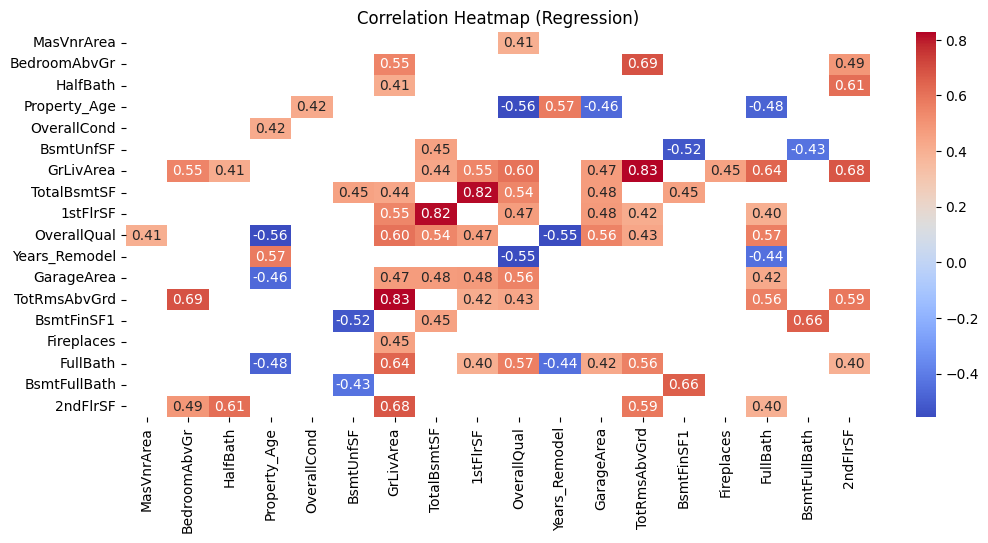

In [64]:
corr_matrix = correlation_analysis (train_final, y_train, graphic='yes', threshold=0.4, numeric_cols=numerical_non_binary_columns(train_final))

### 8. Prediction and Submission

In [65]:
# Initialize the model with the best parameters
best_model = LGBMRegressor(n_estimators=100, max_depth=15, learning_rate=0.05, random_state=42, early_stopping_rounds=5, verbosity=-1, num_leaves=31, colsample_bytree=0.8) #Best option

# Fit the model on the full training dataset
best_model.fit(train_final, y_train, eval_set=[(valid_final, y_val)]) #LGBM

# Predict on the valid data
predictions = best_model.predict(valid_final).astype('float').round(2)

MSE = round(mean_squared_error(y_val, predictions),2)

MAE = round(mean_absolute_error(y_val, predictions),2)

print(f'MSE: {MSE} \nMAE: {MAE}')

MSE: 510148850.25 
MAE: 15466.11


In [36]:
# Predict on the test data
predictions = best_model.predict(test_final).astype('float').round(2)

# Export to .csv file
output = pd.DataFrame({'Id': test_final.index, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print('Done')

Done
